In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch, torch.nn as nn
import torch.nn.functional as F


from utils import data_clean, feature_align
from utils.data_clean import clean_cust_df, clean_event_df, clean_product_xlsx
from utils.feature_align import align_product_features

cust_df = data_clean.clean_cust_df('./raw_data/cust_dataset.csv')
event_df = data_clean.clean_event_df('./raw_data/event_dataset.csv')
product_df = data_clean.clean_product_xlsx('./raw_data/productLabels_multiSpreadsheets.xlsx')

# 对齐不同类别的产品特征
aligned_dict = align_product_features(product_df, min_numeric_cols=4)
for category, data in aligned_dict.items():
    df = data['df']  # 该类别的产品DataFrame
    numeric_cols = data['numeric_cols']  # 该类别可用的数值列
    print(f"类别 {category}: {len(numeric_cols)} 个数值特征")

[CLEAN] cust_df cleaned: (1108827, 5), columns=['cust_no', 'gender', 'age', 'edu_bg', 'marriage_situ_cd']
所有唯一的产品类别 (Unique prod_cat): ['A', 'C', 'D', 'N', 'P']
[CLEAN] event_df cleaned: (338939, 27), columns=['cust_no', 'prod_id', 'event_id', 'event_type', 'event_level', 'event_date', 'event_term', 'event_rate', 'event_amt', 'A', 'B', 'D', 'is_success', 'event_level_A', 'event_level_B', 'event_level_C', 'prod_cat', 'prev_count_A', 'prev_count_A_neg', 'prev_count_C', 'prev_count_C_neg', 'prev_count_D', 'prev_count_D_neg', 'prev_count_N', 'prev_count_N_neg', 'prev_count_P', 'prev_count_P_neg']
[CLEAN] product_df cleaned: (270, 19), sheets=['D', 'C', 'A', 'N', 'P']
类别 D: 16 个数值特征
类别 C: 16 个数值特征
类别 A: 16 个数值特征
类别 N: 16 个数值特征
类别 P: 16 个数值特征


### 合并数据 & 根据产品种类分组 & 删除产品特征

In [6]:
#==== 合并数据 ====#
merged_df = pd.merge(event_df, cust_df, on='cust_no', how='left')
merged_df = pd.merge(merged_df, product_df, on='prod_id', how='left')
merged_df.fillna(0, inplace=True)
merged_df = merged_df.drop(['cust_no','event_level','event_type','event_date','A','B','D','__sheet__'],axis=1)

# 定义需要保留为object类型的列
cols_to_keep_as_object = ['prod_id', 'prod_cat']
cols_to_convert = merged_df.columns.difference(cols_to_keep_as_object)
merged_df[cols_to_convert] = merged_df[cols_to_convert].astype('float32')

#==== 根据prod_cat分组 ====#
# 获取所有唯一的产品类别（通常为 A, C, D, N, P）
unique_cats = sorted([cat for cat in merged_df['prod_cat'].unique() if str(cat).strip() != ''])
print(f"产品类别: {unique_cats}")
print(f"\n各类别数据量:")

# 创建分组数据框（使用字典动态创建，然后提取为独立变量）
merged_df_dict = {}
for cat in unique_cats:
    cat_str = str(cat).strip()
    if cat_str:  # 确保类别不为空
        df_name = f"merged_df_{cat_str}"
        merged_df_dict[cat_str] = merged_df[merged_df['prod_cat'] == cat_str].copy()
        print(f"merged_df_{cat_str}: {len(merged_df_dict[cat_str])} 行, {merged_df_dict[cat_str].shape[1]} 列")

# 创建独立的变量
merged_df_A = merged_df_dict.get('A', pd.DataFrame())
merged_df_C = merged_df_dict.get('C', pd.DataFrame())
merged_df_D = merged_df_dict.get('D', pd.DataFrame())
merged_df_N = merged_df_dict.get('N', pd.DataFrame())
merged_df_P = merged_df_dict.get('P', pd.DataFrame())

#==== 对prod_id进行聚合 ====#
import ast

merged_dict = {
    "A": merged_df_A,
    "C": merged_df_C,
    "D": merged_df_D,
    "N": merged_df_N,
    "P": merged_df_P
}
cluster_dict = pd.read_excel("./cluster_products/first_cluster.xlsx",sheet_name=None)

for cat in unique_cats:
    merged_df = merged_dict[cat]
    cluster_df = cluster_dict[cat]
    # 将字符串转为真实列表

    cluster_df["prod_id"] = cluster_df["prod_id"].apply(ast.literal_eval)
    # 构建映射字典
    mapping = {}
    for _, row in cluster_df.iterrows():
        group_list = row["prod_id"]
        for pid in group_list:
            mapping[pid] = group_list
    # 添加聚类结果列
    merged_df["prod_group"] = merged_df["prod_id"].map(mapping)
    # 更新到字典
    merged_dict[cat] = merged_df

#取回结果:
merged_df_A = merged_dict["A"]
merged_df_A = merged_df_A.drop(columns = ['prod_id'])
merged_df_C = merged_dict["C"]
merged_df_C = merged_df_C.drop(columns = ['prod_id'])
merged_df_D = merged_dict["D"]
merged_df_D = merged_df_D.drop(columns = ['prod_id'])
merged_df_N = merged_dict["N"]
merged_df_N = merged_df_N.drop(columns = ['prod_id'])
merged_df_P = merged_dict["P"]
merged_df_P = merged_df_P.drop(columns = ['prod_id'])

#==== 删除产品特征 ====#
# 要剔除的产品特征列
cols_to_drop = [
    'interval_level', 'deposit_type1', 'deposit_type2',
    'credit_level', 'credit_amt_cd', 'credit_type1', 'credit_type2', 'new_flag',
    'frtn_type', 'fr_period_type', 'fr_prod_attr', 'fr_prod_type', 'fr_risk_level',
    'channel_type', 'channel_type2',
    'pay_type1', 'pay_type2'
]

# 要处理的 DataFrame 列表
dfs = {
    'A': merged_df_A,
    'C': merged_df_C,
    'D': merged_df_D,
    'N': merged_df_N,
    'P': merged_df_P
}

# 检查并删除
for name, df in dfs.items():
    # 找出当前 df 中存在的特征列
    existing = [c for c in cols_to_drop if c in df.columns]
    
    if existing:
        print(f"✅ {name}: 删除列 {existing}")
        dfs[name] = df.drop(columns=existing)
    else:
        print(f"⚪ {name}: 无需删除（未包含这些列）")

merged_df_A, merged_df_C, merged_df_D, merged_df_N, merged_df_P = dfs.values()

#==== 删除is_success为0的数据 ====#
def drop_unsuccessful(df,name):
    """删除 is_success == 0 的行"""
    before = len(df)
    df_filtered = df[df['is_success'] != 0].copy()
    after = len(df_filtered)
    print(f"✅ merged_df_{name}, 已删除 {before - after} 行 is_success == 0 的记录，剩余 {after} 行。")
    return df_filtered

merged_df_A = drop_unsuccessful(merged_df_A,"A")
merged_df_C = drop_unsuccessful(merged_df_C,"C")
merged_df_D = drop_unsuccessful(merged_df_D,"D")
merged_df_N = drop_unsuccessful(merged_df_N,"N")
merged_df_P = drop_unsuccessful(merged_df_P,"P")

产品类别: ['A', 'C', 'D', 'N', 'P']

各类别数据量:
merged_df_A: 4575 行, 41 列
merged_df_C: 44637 行, 41 列
merged_df_D: 253949 行, 41 列
merged_df_N: 26555 行, 41 列
merged_df_P: 9223 行, 41 列
✅ A: 删除列 ['interval_level', 'deposit_type1', 'deposit_type2', 'credit_level', 'credit_amt_cd', 'credit_type1', 'credit_type2', 'new_flag', 'frtn_type', 'fr_period_type', 'fr_prod_attr', 'fr_prod_type', 'fr_risk_level', 'channel_type', 'channel_type2', 'pay_type1', 'pay_type2']
✅ C: 删除列 ['interval_level', 'deposit_type1', 'deposit_type2', 'credit_level', 'credit_amt_cd', 'credit_type1', 'credit_type2', 'new_flag', 'frtn_type', 'fr_period_type', 'fr_prod_attr', 'fr_prod_type', 'fr_risk_level', 'channel_type', 'channel_type2', 'pay_type1', 'pay_type2']
✅ D: 删除列 ['interval_level', 'deposit_type1', 'deposit_type2', 'credit_level', 'credit_amt_cd', 'credit_type1', 'credit_type2', 'new_flag', 'frtn_type', 'fr_period_type', 'fr_prod_attr', 'fr_prod_type', 'fr_risk_level', 'channel_type', 'channel_type2', 'pay_type1', 'pay

### 创建训练字典

In [7]:
#==== 创建训练model_dict ====#
model_dict = {
    "A": merged_df_A,
    "C": merged_df_C,
    "D": merged_df_D,
    "N": merged_df_N,
    "P": merged_df_P
}

### 模型定义 & 训练模型

In [8]:
# ============= 模型定义 =============#

# ============= 定义Factorization Machine (FM)组件 =============
class FM(nn.Module):
    """Factorization Machine - 捕捉特征间的二阶交互"""
    def __init__(self, num_features, k):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)  # 线性部分
        self.V = nn.Parameter(torch.randn(num_features, k))  # 隐向量矩阵
        # 初始化
        nn.init.normal_(self.V, mean=0, std=0.01)
        
    def forward(self, x):
        # x shape: [batch, num_features]
        # 线性部分
        linear_part = self.linear(x)  # [batch, 1]
        
        # 交互部分: 使用优化的FM公式
        # sum((x*V)^2 - (x^2)*(V^2)) / 2
        inter_1 = torch.pow(torch.mm(x, self.V), 2)  # [batch, k]
        inter_2 = torch.mm(torch.pow(x, 2), torch.pow(self.V, 2))  # [batch, k]
        interaction_part = 0.5 * torch.sum(inter_1 - inter_2, dim=1, keepdim=True)  # [batch, 1]
        
        return linear_part + interaction_part


# ============= 定义融合Transformer和FM的模型 =============
class ProductTransformerFM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.2, num_heads=4, fm_k=16, fusion='concat'):
        """
        Args:
            input_dim: 输入特征维度
            hidden_dim: Transformer隐藏维度
            num_classes: 输出类别数
            num_layers: Transformer层数
            dropout: Dropout率
            num_heads: 注意力头数
            fm_k: FM隐向量维度
            fusion: 融合方式 ('concat' 或 'add')
        """
        super(ProductTransformerFM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.fusion = fusion
        
        # ========== Transformer部分 ==========
        # 位置编码
        self.pos_embedding = nn.Parameter(torch.randn(1, input_dim, hidden_dim))
        # 输入投影层
        self.input_proj = nn.Linear(1, hidden_dim)
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        # Transformer Encoder层
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # ========== FM部分 ==========
        self.fm = FM(num_features=input_dim, k=fm_k)
        
        # ========== 融合层 ==========
        if fusion == 'concat':
            # 将Transformer输出和FM输出concat
            fusion_dim = hidden_dim + 1  # FM输出是标量
            self.fusion_proj = nn.Linear(fusion_dim, hidden_dim)
        else:  # fusion == 'add'
            # FM输出投影到hidden_dim后相加
            self.fm_proj = nn.Linear(1, hidden_dim)
            fusion_dim = hidden_dim
        
        # ========== 输出层 ==========
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim * 2, num_classes)
        
        # 初始化权重
        self._init_weights()
        
    def _init_weights(self):
        """初始化模型权重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        # x shape: [batch, input_dim]
        batch_size = x.size(0)
        
        # ========== Transformer路径 ==========
        # Reshape成序列: [batch, seq_len, 1]
        x_reshaped = x.unsqueeze(2)  # [batch, input_dim, 1]
        # 输入投影
        x_proj = self.input_proj(x_reshaped)  # [batch, input_dim, hidden_dim]
        # 添加位置编码
        x_proj = x_proj + self.pos_embedding  # [batch, input_dim, hidden_dim]
        # 添加CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch, 1, hidden_dim]
        x_proj = torch.cat([cls_tokens, x_proj], dim=1)  # [batch, input_dim+1, hidden_dim]
        # Transformer编码
        x_transformed = self.transformer(x_proj)  # [batch, input_dim+1, hidden_dim]
        # 使用CLS token的输出作为序列表示
        transformer_output = x_transformed[:, 0, :]  # [batch, hidden_dim]
        
        # ========== FM路径 ==========
        fm_output = self.fm(x)  # [batch, 1]
        
        # ========== 融合两部分 ==========
        if self.fusion == 'concat':
            # 将FM输出和Transformer输出concat
            fused = torch.cat([transformer_output, fm_output], dim=1)  # [batch, hidden_dim + 1]
            fused = self.fusion_proj(fused)  # [batch, hidden_dim]
        else:  # fusion == 'add'
            # 将FM输出投影到hidden_dim后相加
            fm_proj = self.fm_proj(fm_output)  # [batch, hidden_dim]
            fused = transformer_output + fm_proj  # [batch, hidden_dim]
        
        # ========== 输出层 ==========
        out = self.fc1(fused)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

print("模型类定义完成")

模型类定义完成


In [9]:
#============= 分组训练函数 =============#
def train_category_model(category, df_category, model_config, train_config, save_dir='outputs'):
    """
    为单个类别训练模型
    
    参数:
        category: 类别名称 (如 'A', 'C', 'D', 'N', 'P')
        df_category: 该类别的数据框
        model_config: 模型配置字典
        train_config: 训练配置字典
        save_dir: 模型保存目录
    
    返回:
        model: 训练好的模型
        id2idx: 产品ID到索引的映射
        idx2prod: 索引到产品ID的映射
        train_history: 训练历史记录
    """
    import os
    
    print(f"\n{'='*60}")
    print(f"开始训练类别 {category} 的模型")
    print(f"{'='*60}")
    print(f"数据量: {len(df_category)} 行")
    
    # 1. 为该类别创建prod_id映射
    unique_prods = df_category['prod_group'].astype(str).unique().tolist()
    PAD, OOV = 0, 1
    id2idx = {p: i+2 for i, p in enumerate(unique_prods)}
    num_items = len(id2idx) + 2
    idx2prod = {v: k for k, v in id2idx.items()}
    
    print(f"类别 {category} 的产品数量: {num_items - 2}")
    
    def prod_to_idx(pid: str) -> int:
        return id2idx.get(str(pid), OOV)
    
    # 2. 准备数据
    def prepare_data(df):
        feature_cols = [col for col in df.columns if col not in ['prod_group', 'prod_cat']]
        X = df[feature_cols].values.astype(np.float32)
        y = df['prod_group'].astype(str).apply(prod_to_idx).values
        return X, y
    
    X, y = prepare_data(df_category)
    print(f"特征维度: {X.shape[1]}, 类别数: {num_items}")
    
    # 3. 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )
    print(f"训练集: {len(X_train)}, 测试集: {len(X_test)}")
    
    # 4. 创建Dataset和DataLoader
    class CategoryDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.FloatTensor(X)
            self.y = torch.LongTensor(y)
        
        def __len__(self):
            return len(self.X)
        
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]
    
    train_dataset = CategoryDataset(X_train, y_train)
    test_dataset = CategoryDataset(X_test, y_test)
    
    batch_size = train_config.get('batch_size', 128)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 5. 创建模型（使用该类别的特征维度和类别数）
    input_dim = X.shape[1]
    num_classes = num_items
    
    model = ProductTransformerFM(
        input_dim=input_dim,
        hidden_dim=model_config.get('hidden_dim', 128),
        num_classes=num_classes,
        num_layers=model_config.get('num_layers', 2),
        dropout=model_config.get('dropout', 0.2),
        num_heads=model_config.get('num_heads', 4),
        fm_k=model_config.get('fm_k', 16),
        fusion=model_config.get('fusion', 'concat')
    ).to(train_config['device'])
    
    print(f"模型创建完成: input_dim={input_dim}, num_classes={num_classes}")
    
    # 6. 设置训练参数
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=train_config.get('lr', 0.001), 
        weight_decay=train_config.get('weight_decay', 1e-5)
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    num_epochs = train_config.get('num_epochs', 5)
    print_every = train_config.get('print_every', 100)
    
    # 7. 训练历史
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # 8. 训练循环
    print(f"\n开始训练类别 {category} 的模型...")
    for epoch in range(num_epochs):
        # 训练模式
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.to(train_config['device'])
            y_batch = y_batch.to(train_config['device'])
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # 反向传播
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # 统计
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
            
            # 打印进度
            if (batch_idx + 1) % print_every == 0:
                current_acc = 100 * train_correct / train_total
                print(f'类别 {category} - Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Acc: {current_acc:.2f}%')
        
        # 计算平均指标
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        
        # 验证
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(train_config['device'])
                y_batch = y_batch.to(train_config['device'])
                
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
        
        avg_val_loss = val_loss / len(test_loader)
        avg_val_acc = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)
        
        scheduler.step(avg_val_loss)
        
        print(f'类别 {category} - Epoch [{epoch+1}/{num_epochs}] 完成:')
        print(f'  训练 - Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.2f}%')
        print(f'  验证 - Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.2f}%')
        print('-' * 60)
    
    # 9. 保存模型
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f'transformer_fm_product_classifier_{category}.pth')
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': 'ProductTransformerFM',
        'category': category,
        'id2idx': id2idx,
        'idx2prod': idx2prod,
        'num_items': num_items,
        'input_dim': input_dim,
        'hidden_dim': model_config.get('hidden_dim', 128),
        'num_layers': model_config.get('num_layers', 2),
        'num_heads': model_config.get('num_heads', 4),
        'fm_k': model_config.get('fm_k', 16),
        'fusion': model_config.get('fusion', 'concat'),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, model_path)
    
    print(f"\n类别 {category} 的模型已保存到: {model_path}")
    print(f"最佳训练准确率: {max(train_accuracies):.2f}%")
    print(f"最佳验证准确率: {max(val_accuracies):.2f}%")
    
    train_history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
    
    return model, id2idx, idx2prod, train_history

print("分组训练函数定义完成！")

分组训练函数定义完成！


In [10]:
#============= 配置训练参数 =============#
# 模型配置
model_config = {
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.2,
    'num_heads': 4,
    'fm_k': 16,
    'fusion': 'concat'  # 'concat' 或 'add'
}

# 训练配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

train_config = {
    'device': device,
    'batch_size': 128,
    'lr': 0.001,
    'weight_decay': 1e-5,
    'num_epochs': 5,
    'print_every': 50  # 每50个batch打印一次
}

print("训练配置:")
print(f"  模型配置: {model_config}")
print(f"  训练配置: {train_config}")
print(f"  设备: {device}")

使用设备: cpu
训练配置:
  模型配置: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2, 'num_heads': 4, 'fm_k': 16, 'fusion': 'concat'}
  训练配置: {'device': device(type='cpu'), 'batch_size': 128, 'lr': 0.001, 'weight_decay': 1e-05, 'num_epochs': 5, 'print_every': 50}
  设备: cpu


In [11]:
#============= 对每个类别进行分组训练 =============#

# 存储所有训练好的模型和相关信息
trained_models = {}
trained_id2idx = {}
trained_idx2prod = {}
trained_histories = {}

# 要训练的类别列表
categories_to_train = ['A', 'C', 'D', 'N', 'P']

print(f"开始对 {len(categories_to_train)} 个类别进行分组训练...")
print(f"类别列表: {categories_to_train}\n")

# 对每个类别进行训练
for category in categories_to_train:
    if category in model_dict and len(model_dict[category]) > 0:
        try:
            # 训练该类别的模型
            model, id2idx, idx2prod, history = train_category_model(
                category=category,
                df_category=model_dict[category],
                model_config=model_config,
                train_config=train_config,
                save_dir='outputs'
            )
            
            # 保存模型和相关信息
            trained_models[category] = model
            trained_id2idx[category] = id2idx
            trained_idx2prod[category] = idx2prod
            trained_histories[category] = history
            
            print(f"\n✓ 类别 {category} 训练完成！")
            print(f"  模型已保存，最佳验证准确率: {max(history['val_accuracies']):.2f}%")
            print(f"  产品数量: {len(id2idx)}")
            
        except Exception as e:
            print(f"\n✗ 类别 {category} 训练失败: {str(e)}")
            import traceback
            traceback.print_exc()
    else:
        print(f"\n⚠ 类别 {category} 没有数据，跳过训练")

print(f"\n{'='*60}")
print(f"分组训练完成！")
print(f"成功训练 {len(trained_models)} 个类别模型")
print(f"{'='*60}")

开始对 5 个类别进行分组训练...
类别列表: ['A', 'C', 'D', 'N', 'P']


开始训练类别 A 的模型
数据量: 4575 行
类别 A 的产品数量: 8
特征维度: 22, 类别数: 10
训练集: 3660, 测试集: 915
模型创建完成: input_dim=22, num_classes=10

开始训练类别 A 的模型...
类别 A - Epoch [1/5] 完成:
  训练 - Loss: 5.0440, Acc: 26.61%
  验证 - Loss: 1.7807, Acc: 38.47%
------------------------------------------------------------
类别 A - Epoch [2/5] 完成:
  训练 - Loss: 1.9354, Acc: 30.68%
  验证 - Loss: 1.6251, Acc: 38.47%
------------------------------------------------------------
类别 A - Epoch [3/5] 完成:
  训练 - Loss: 1.7199, Acc: 35.38%
  验证 - Loss: 1.6419, Acc: 38.47%
------------------------------------------------------------
类别 A - Epoch [4/5] 完成:
  训练 - Loss: 1.6631, Acc: 36.94%
  验证 - Loss: 1.6627, Acc: 38.47%
------------------------------------------------------------
类别 A - Epoch [5/5] 完成:
  训练 - Loss: 1.6370, Acc: 38.14%
  验证 - Loss: 1.6168, Acc: 38.47%
------------------------------------------------------------

类别 A 的模型已保存到: outputs\transformer_fm_product_classifier_A.pth
最佳训

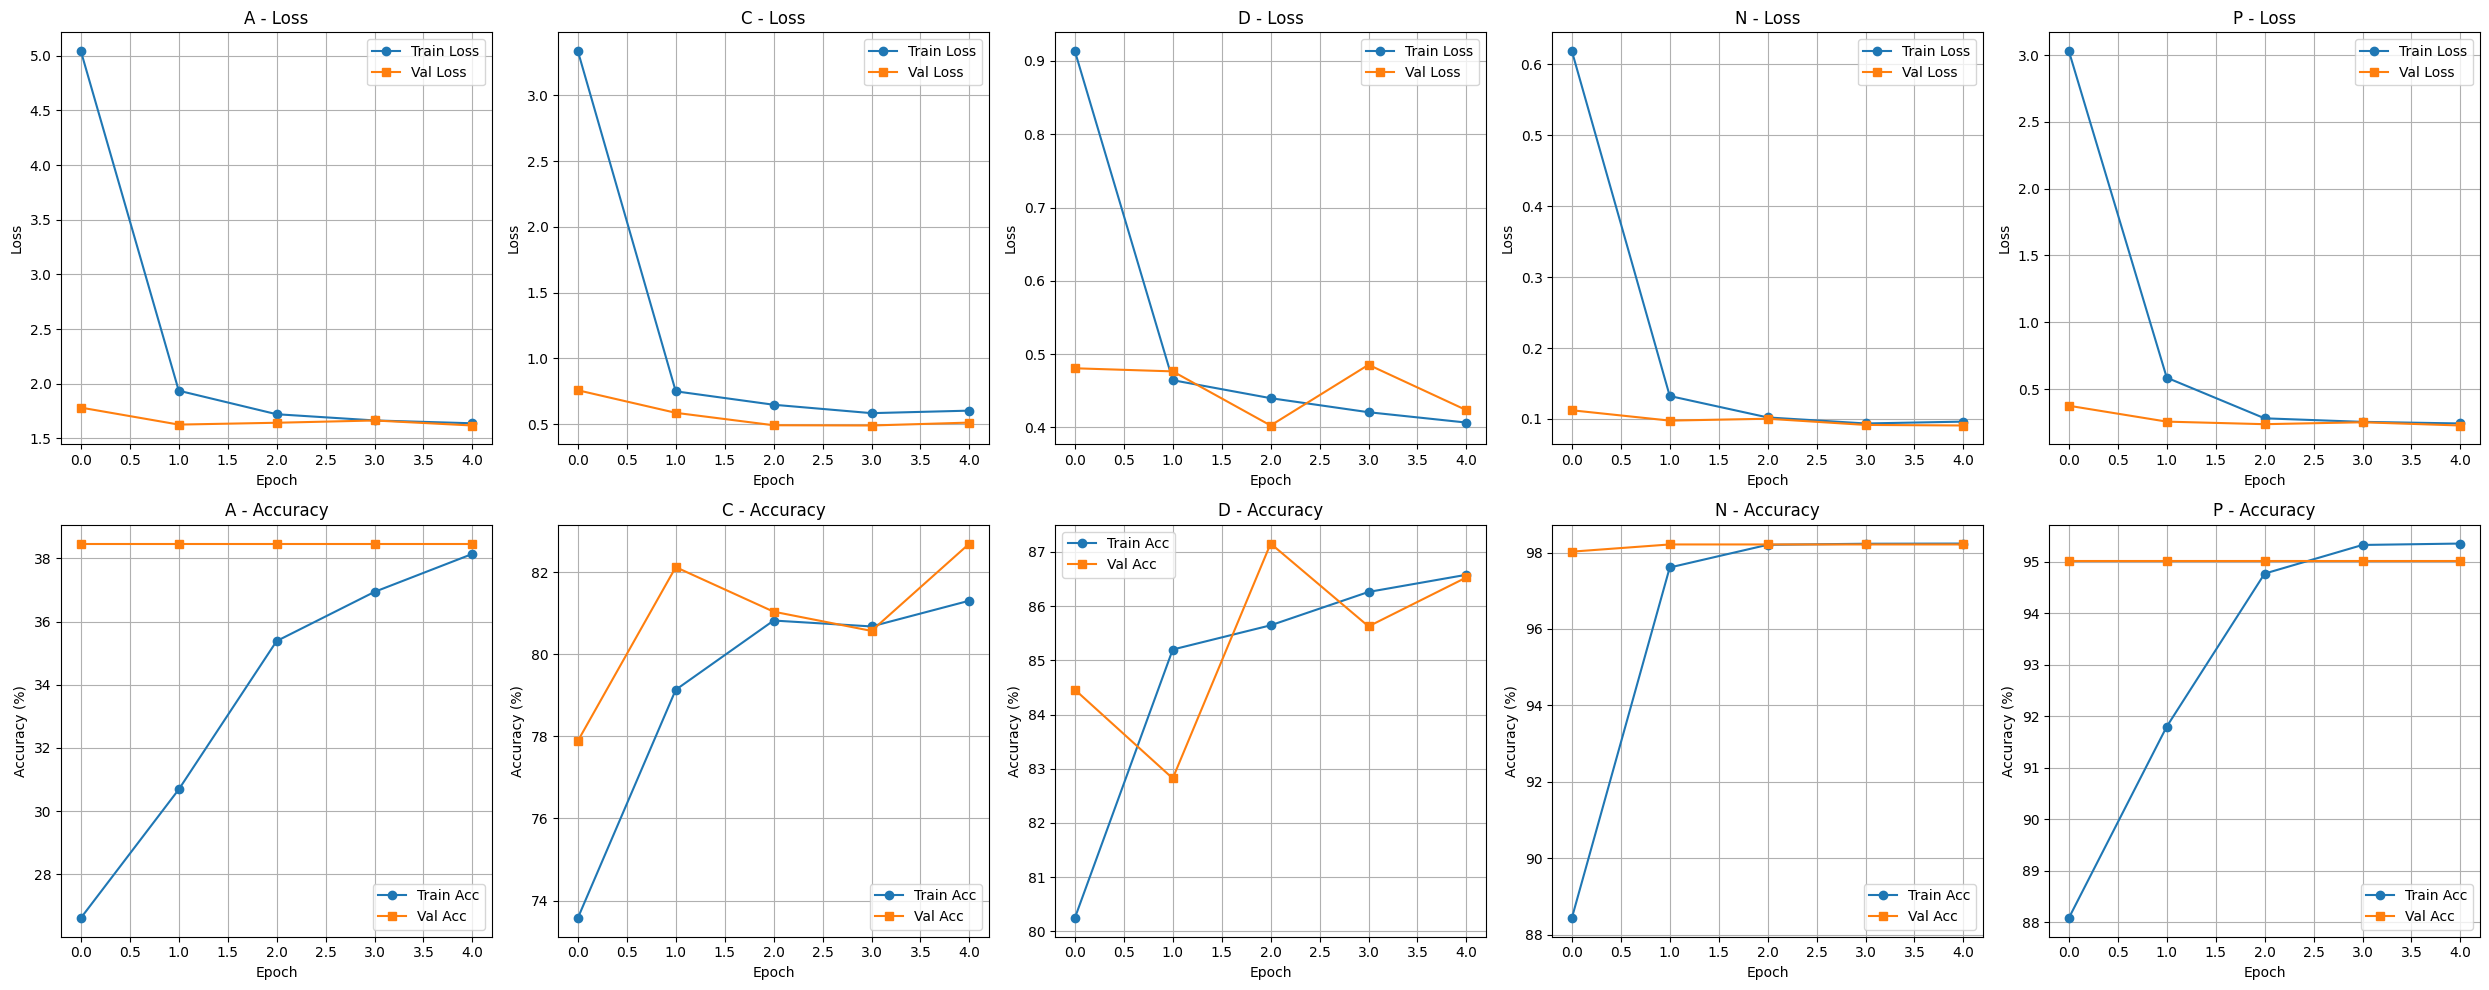


训练结果总结:
--------------------------------------------------------------------------------
类别 A:
  产品数量: 8
  最佳训练准确率: 38.14%
  最佳验证准确率: 38.47%

类别 C:
  产品数量: 26
  最佳训练准确率: 81.31%
  最佳验证准确率: 82.70%

类别 D:
  产品数量: 12
  最佳训练准确率: 86.58%
  最佳验证准确率: 87.16%

类别 N:
  产品数量: 3
  最佳训练准确率: 98.23%
  最佳验证准确率: 98.21%

类别 P:
  产品数量: 3
  最佳训练准确率: 95.35%
  最佳验证准确率: 95.01%



In [12]:
#============= 可视化所有类别的训练结果 =============#
import matplotlib.pyplot as plt

# 创建图表
fig, axes = plt.subplots(2, len(trained_models), figsize=(5*len(trained_models), 10))
if len(trained_models) == 1:
    axes = axes.reshape(2, 1)

for idx, (category, history) in enumerate(trained_histories.items()):
    # 损失曲线
    ax1 = axes[0, idx]
    ax1.plot(history['train_losses'], label='Train Loss', marker='o')
    ax1.plot(history['val_losses'], label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{category} - Loss')
    ax1.legend()
    ax1.grid(True)
    
    # 准确率曲线
    ax2 = axes[1, idx]
    ax2.plot(history['train_accuracies'], label='Train Acc', marker='o')
    ax2.plot(history['val_accuracies'], label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{category} - Accuracy')
    ax2.legend()
    ax2.grid(True)

plt.tight_layout()
plt.show()

# 打印总结
print("\n训练结果总结:")
print("-" * 80)
for category, history in trained_histories.items():
    best_train_acc = max(history['train_accuracies'])
    best_val_acc = max(history['val_accuracies'])
    num_products = len(trained_id2idx[category])
    print(f"类别 {category}:")
    print(f"  产品数量: {num_products}")
    print(f"  最佳训练准确率: {best_train_acc:.2f}%")
    print(f"  最佳验证准确率: {best_val_acc:.2f}%")
    print()

In [13]:
# ============= 保存所有模型信息的汇总 =============
import json

# 创建汇总信息
summary = {
    'total_categories': len(trained_models),
    'categories': list(trained_models.keys()),
    'model_config': model_config,
    'train_config': {
        k: str(v) if not isinstance(v, (int, float, bool)) else v 
        for k, v in train_config.items()
    },
    'results': {}
}

for category in trained_models.keys():
    history = trained_histories[category]
    summary['results'][category] = {
        'num_products': len(trained_id2idx[category]),
        'best_train_acc': max(history['train_accuracies']),
        'best_val_acc': max(history['val_accuracies']),
        'final_train_acc': history['train_accuracies'][-1],
        'final_val_acc': history['val_accuracies'][-1],
        'model_path': f'outputs/transformer_fm_product_classifier_{category}.pth'
    }

# 保存汇总信息
summary_path = 'outputs/transformer_training_summary.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"训练汇总已保存到: {summary_path}")
print("\n训练汇总:")
print(json.dumps(summary, indent=2, ensure_ascii=False))

训练汇总已保存到: outputs/transformer_training_summary.json

训练汇总:
{
  "total_categories": 5,
  "categories": [
    "A",
    "C",
    "D",
    "N",
    "P"
  ],
  "model_config": {
    "hidden_dim": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_heads": 4,
    "fm_k": 16,
    "fusion": "concat"
  },
  "train_config": {
    "device": "cpu",
    "batch_size": 128,
    "lr": 0.001,
    "weight_decay": 1e-05,
    "num_epochs": 5,
    "print_every": 50
  },
  "results": {
    "A": {
      "num_products": 8,
      "best_train_acc": 38.14207650273224,
      "best_val_acc": 38.46994535519126,
      "final_train_acc": 38.14207650273224,
      "final_val_acc": 38.46994535519126,
      "model_path": "outputs/transformer_fm_product_classifier_A.pth"
    },
    "C": {
      "num_products": 26,
      "best_train_acc": 81.3068695790986,
      "best_val_acc": 82.69844647797403,
      "final_train_acc": 81.3068695790986,
      "final_val_acc": 82.69844647797403,
      "model_path": "outputs/transformer